# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [3]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("/content/drive/My Drive/ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


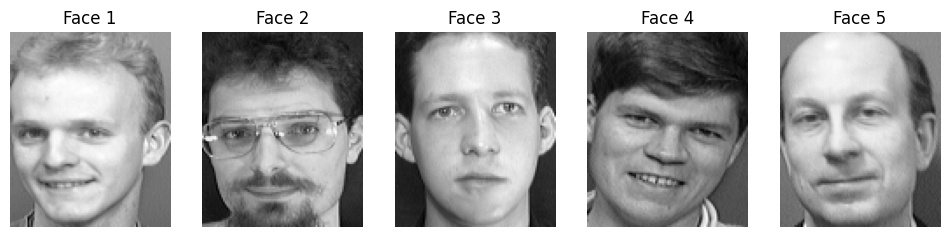

In [4]:
# visualising the first 5 faces
fig, ax = plt.subplots(1, 5, figsize=(12, 12))
for i in range(5):
    ax[i].imshow(trainFaces[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Face {i+1}')
plt.show()

#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [5]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """

    # your code here
    # reshaping the images to 2D
    X = X.reshape(X.shape[0], -1)
    # mean centering the data  about origin
    Xmeaned = X - np.mean(X, axis=0)
    # finding the covariance matrix
    cov = np.cov(Xmeaned, rowvar=False)
    # finding the eigen values and eigen vectors
    eigVal, eigVec = np.linalg.eigh(cov)
    # we know that the first pca will have the highest eigen value
    # so we sort the eigen vectors and values in descending order
    sortedInd = np.argsort(eigVal)[::-1]
    sortedEigVal = eigVal[sortedInd]
    sortedEigVec = eigVec[:, sortedInd]
    # we take the first numComponents eigen vectors which will be the principal components
    return sortedEigVec



The method implements Principal Component Analysis, a technique for dimensionality reduction. It first centers the data around the mean, computes the covariance matrix, then performs eigen decomposition to find eigenvectors and eigenvalues. These are sorted by eigenvalue magnitude, and the top numComponents eigenvectors are selected as principal components, capturing the most significant variations in the data.

In [6]:
eigenFaces = principalComponentAnalysis(trainFaces, 10)

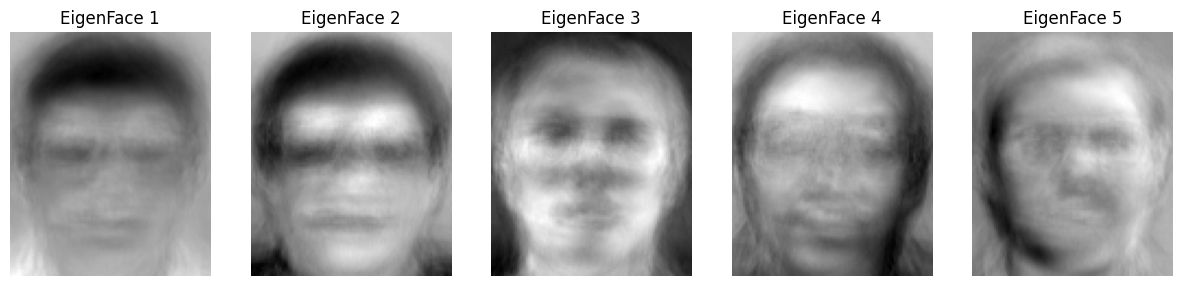

In [7]:
# plot the eigen faces for first 5 components
%matplotlib inline
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(eigenFaces[:, i].reshape(112, 92), cmap='gray')
    axes[i].set_title("EigenFace " + str(i+1))
    axes[i].axis('off')
plt.show()



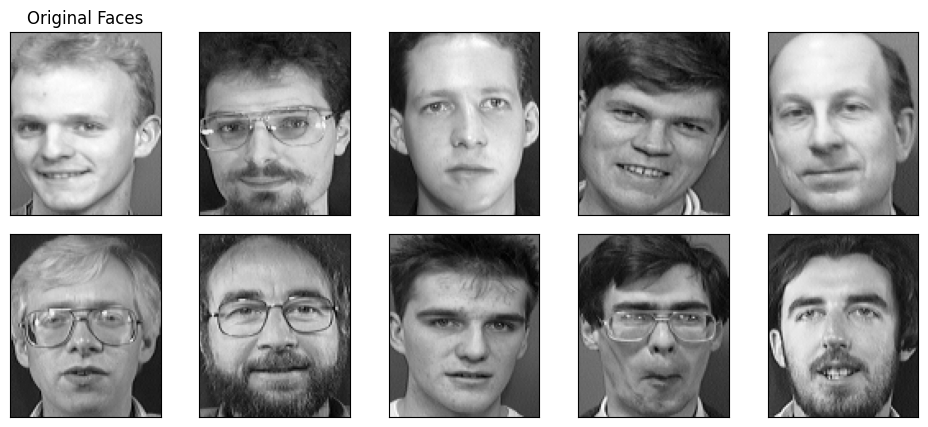

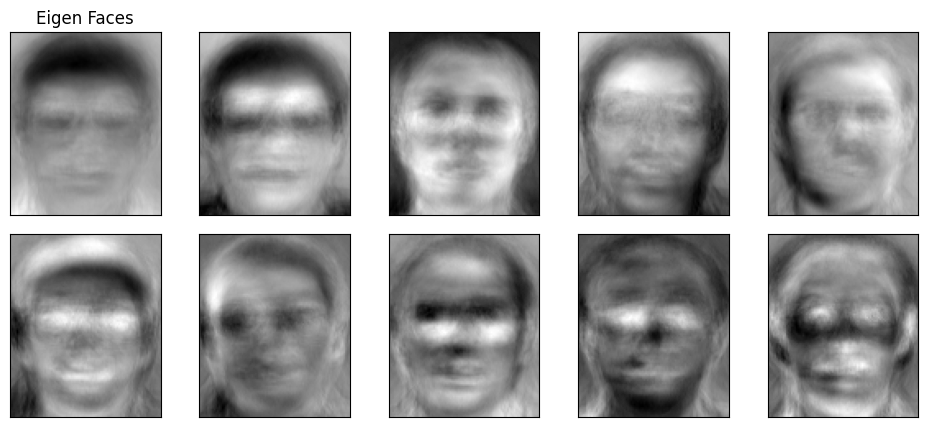

In [8]:
# seeing the actual faces and the eigen faces
def plot_faces(faces, title, num_rows=2, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i in range(num_rows * num_cols):
        axes[i // num_cols, i % num_cols].imshow(faces[i], cmap='gray')
    axes[0, 0].set_title(title)
    plt.show()

plot_faces(trainFaces, 'Original Faces')
# applying pca
numComponents = 10
efs = eigenFaces[:, :10]
plot_faces(efs.T.reshape(-1, 112, 92), 'Eigen Faces')



#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [9]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """
    # your code here
    # flatten the test face
    testFace = testFace.flatten()
    meanFace = meanFace.flatten()
    # project the test face onto the eigen faces
    weights = np.dot(testFace - meanFace, eigenFaces)
    # reconstruct the test face
    reconstructedFace = meanFace + np.dot(weights, eigenFaces.T)
    # reshape test face to original shape
    reconstructedFace = reconstructedFace.reshape(testFace.shape)
    return reconstructedFace



The imageReconstruction function flattens the test and mean faces, projects the test face onto the eigenfaces to obtain weights, then reconstructs the face by adding the mean face and multiplying the weights with the eigenfaces. Finally, it reshapes the reconstructed face to its original dimensions before returning it.

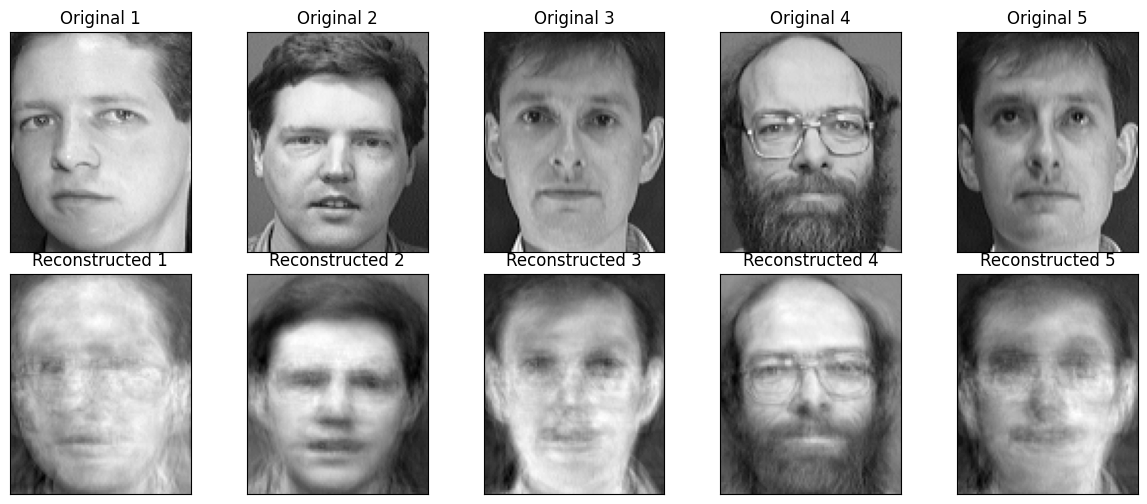

In [10]:
def plot_reconstructed_faces(original_faces, reconstructed_faces, title, num_cols=5):
    fig, axes = plt.subplots(2, num_cols, figsize=(15, 6),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i in range(num_cols):
        axes[0, i].imshow(original_faces[i], cmap='gray')
        axes[0, i].set_title("Original " + str(i+1))
        axes[1, i].imshow(reconstructed_faces[i], cmap='gray')
        axes[1, i].set_title("Reconstructed " + str(i+1))
    plt.show()

# Plot original and reconstructed faces side by side for 100 PCs
num_faces_to_visualize = 5
efs = eigenFaces[:, :100]

meanFace = np.mean(trainFaces, axis=0)
reconstructed_faces = []
for i in range(num_faces_to_visualize):
    reconstructed_face = imageReconstruction(testFaces[i], efs, meanFace)
    reconstructed_faces.append(reconstructed_face.reshape(112, 92))

plot_reconstructed_faces(testFaces.reshape(-1, 112, 92)[:num_faces_to_visualize], reconstructed_faces, 'Original vs Reconstructed Faces')


#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

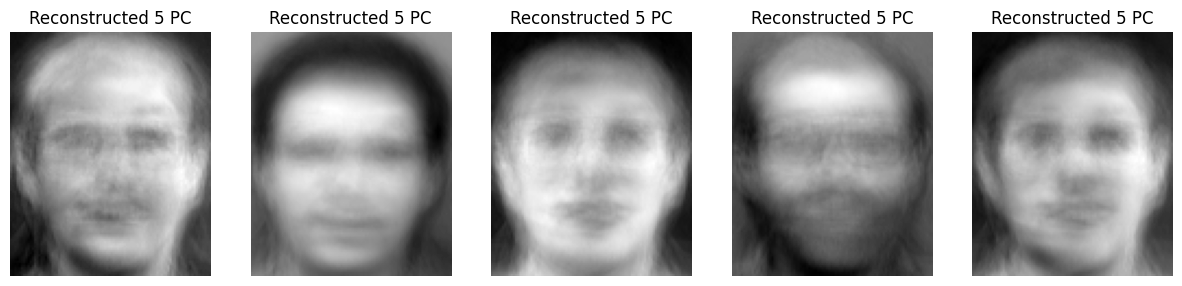

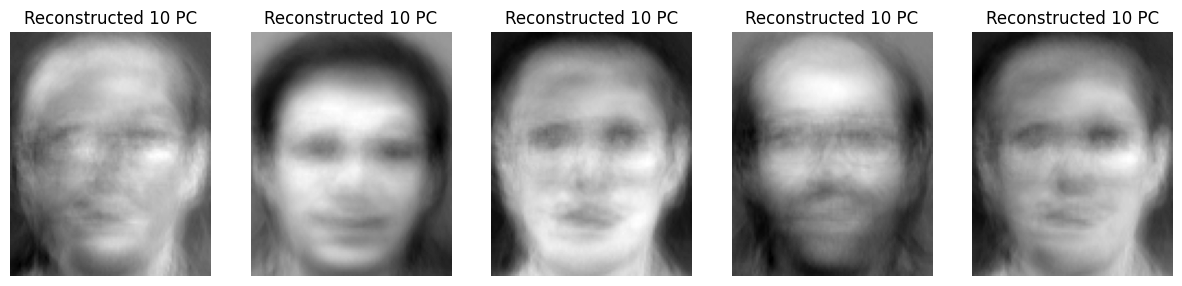

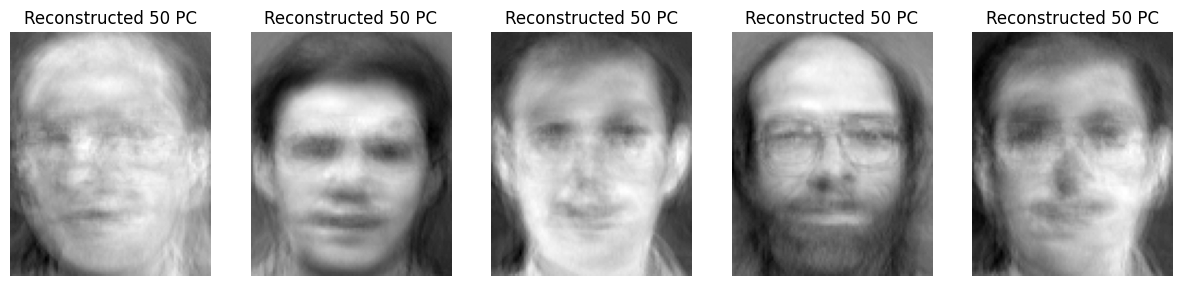

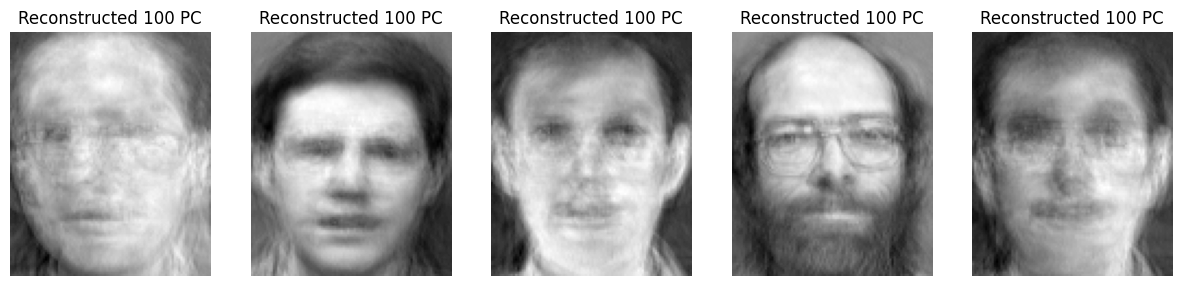

In [12]:
%matplotlib inline

def displayNfactors():
    # List of different numbers of principal components
    compList = [5, 10, 50, 100]

    # Visualize reconstructed images for different numbers of principal components
    for num_components in compList:
        components = eigenFaces[:, :num_components]  # Selecting the first 'num_components' eigenfaces

        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            reconstructedFace = imageReconstruction(testFaces[i], components, meanFace)
            axes[i].imshow(reconstructedFace.reshape(112, 92), cmap='gray')
            axes[i].set_title(f'Reconstructed {num_components} PC')
            axes[i].axis('off')
        plt.show()

    return None

displayNfactors()


The above function visualizes reconstructed images using different numbers of principal components for dimensionality reduction. It iterates over a list of specified numbers of principal components, computes reconstructions of test faces using those components, and displays the reconstructed images. This allows for a visual comparison of the reconstruction quality as the number of principal components varies, demonstrating the impact of dimensionality reduction on image reconstruction.

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [13]:
def getClass(testFaceIndex, trainWeights, testWeights):
    # Compute the Euclidean distances between test face weights and training face weights
    distances = np.linalg.norm(trainWeights - testWeights[testFaceIndex], axis=1)
    # Find the index of the nearest neighbor (minimum distance)
    minIndex = np.argmin(distances)
    # Retrieve the label of the nearest neighbor from training data
    predictedLabel = trainLabels[minIndex]
    # Append the predicted label to the list
    return minIndex, distances[minIndex], predictedLabel



The getClass function determines the closest match (nearest neighbor) for a given test face by computing the Euclidean distances between the test face's weights and the weights of all training faces. It then retrieves the label of the nearest neighbor from the training data and returns the index of the nearest neighbor, the distance to it, and its predicted label.

In [22]:
def faceRecognition(testFaces, trainFaces, trainLabels, eigenFaces):
    # Project training faces onto the eigenfaces
    trainWeights = np.dot(trainFaces.reshape(trainFaces.shape[0], -1), eigenFaces)

    # Project test faces onto the eigenfaces
    testWeights = np.dot(testFaces.reshape(testFaces.shape[0], -1), eigenFaces)

    # Initialize an array to store predicted labels for test faces
    predictedLabels = []
    errors = []
    reconstructedImgs = []

    # Iterate through each test face
    for i in range(testFaces.shape[0]):
      minErrorImg, error, label = getClass(i, trainWeights, testWeights)
      predictedLabels.append(label)
      # errors.append(error)
      # Compute the reconstruction of the test face
      reconstructedFace = imageReconstruction(testFaces[i], eigenFaces, meanFace)
      reconstructedImgs.append(reconstructedFace)
      # Compute and append error between original and reconstructed face
      errors.append(np.linalg.norm(testFaces[i].flatten() - reconstructedFace))

    return predictedLabels, errors, reconstructedImgs


predictedLabels, errors, reconstructedImgs = faceRecognition(testFaces, trainFaces, trainLabels, eigenFaces[:,:10])

In [15]:
testFacesFlat = np.reshape(testFaces, (testFaces.shape[0], -1))
reconstructedImagesFlat = np.reshape(reconstructedImgs, (testFaces.shape[0], -1))
mse = np.mean((testFacesFlat - reconstructedImagesFlat)**2, axis=0)
accuracy = np.mean(predictedLabels == testLabels)
print("The accuracy of the model is", accuracy)
print("The mean squared error is", np.mean(mse))


The accuracy of the model is 0.975
The mean squared error is 683.4404086064835


The above function implements face recognition using eigenfaces. It projects both training and test faces onto the eigenfaces, computes reconstruction errors by comparing original and reconstructed images, and predicts labels for test faces based on the closest match from the training set.

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [19]:
components = [3,5,10,20,30,40,50]
mse = []
eigenCount = []
accuracy = []
mses = []
logarithmicMSE = []
numTestSamples = testFaces.shape[0]

for numComponents in components:
    # your code here
    efs = eigenFaces[:, :numComponents]
    predictedLabels = []

    for i in range(numTestSamples):
        # imgSmallestError, errorVal, predictedLabel = getClass()
        predictedLabels, errors, reconstructedImgs = faceRecognition(testFaces, trainFaces, trainLabels, efs)

    # calculating the accuracy
    acc = np.mean(predictedLabels == testLabels)
    accuracy.append(acc)
    # calculating mse
    testFacesFlat = np.reshape(testFaces, (testFaces.shape[0], -1))
    reconstructedImagesFlat = np.reshape(reconstructedImgs, (testFaces.shape[0], -1))
    mse = np.mean((testFacesFlat - reconstructedImagesFlat)**2, axis=0)
    mses.append(np.mean(mse))
    # calculating the logarithmic mse
    logarithmicMSE.append(np.log(np.mean(np.square(np.mean(mse)))))
    eigenCount.append(numComponents)
    print("The accuracy of the model with", numComponents, "components is", acc)



The accuracy of the model with 3 components is 0.725
The accuracy of the model with 5 components is 0.9
The accuracy of the model with 10 components is 0.975
The accuracy of the model with 20 components is 0.975
The accuracy of the model with 30 components is 0.975
The accuracy of the model with 40 components is 1.0
The accuracy of the model with 50 components is 0.975


Plot Number of eigenvectors vs Mean Square Error

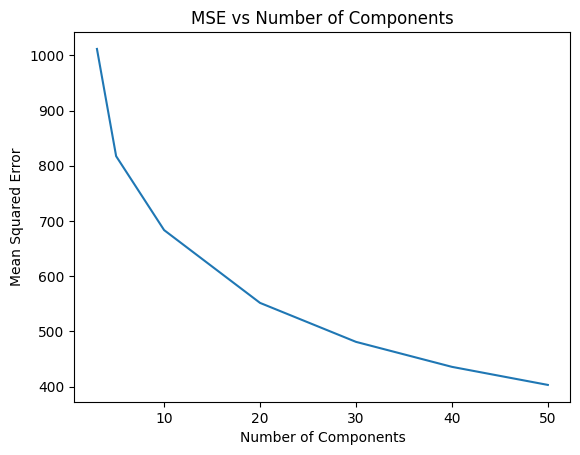

In [20]:
# your code here
plt.plot(eigenCount, mses)
plt.title("MSE vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Mean Squared Error")
plt.show()


Plot Number of eigenvectors vs Logarithmic Mean Square Error

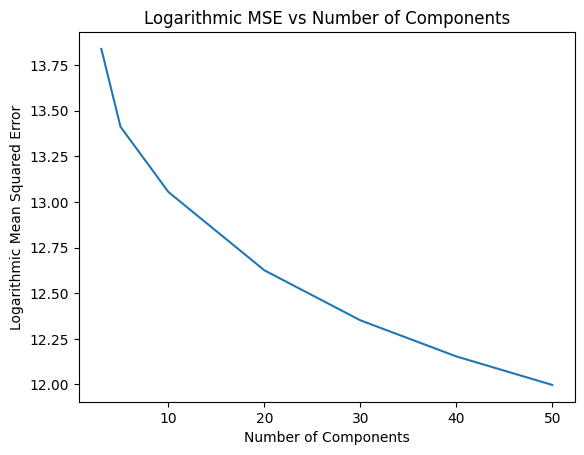

In [21]:
# your code here
plt.plot(eigenCount, logarithmicMSE)
plt.title("Logarithmic MSE vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Logarithmic Mean Squared Error")
plt.show()
